<a href="https://colab.research.google.com/github/malvibid/COMP3029-Computer-Vision/blob/main/COMP3029_Computer_Vision_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMP3029 COMPUTER VISION COURSEWORK** 

*Spring 2022/2023*, School of Computer Science, University of Nottingham Malaysia

```
GROUP 4: 
  20306551 - Mustafa Mehmood
  20311657 - Omar Ismail
  20311860 - Gabriel Hoh Chao Jei
  20187945 - Malvi Bid
```





# ⚡Challenges

```
Key: ✅ Challenge solved 🟥 Pending solution
```

*   ✅ 6 images in Batch-3 were not being segmented correctly. I double-checked the bounding box coordinates and drew them on the image, they were positioned correctly. After further inspection I realised the issue was with the PIL image library we were using. Therefore, I switched to using OpenCV, this resolved the issue. 

# Import Dependencies

In [9]:
import os
import cv2
import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
from google.colab.patches import cv2_imshow

# Mount google drive

In [2]:
# Mount drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Dataset folder structure

In [3]:
!ls -F '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/'

Batch-1/  Batch-2/  Batch-3/


In [ ]:
print("Batch-1/ ")
!ls -F -X '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-1'
print("\nBatch-2/ ")
!ls -F -X '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2'
print("\nBatch-3/ ")
!ls -F -X '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3'

Batch-1/ 
seedsegment@  seedsplit@

Batch-2/ 
NormalRoomLighting@  seedsegment/  NormalRoomLight_annotation.csv

Batch-3/ 
LightBox@  seedsegment/  LightBox_annotation.csv


## Dataset structure tree

### Original folders tree


```
.
└── Datasets/
    ├── Batch-1/
    │   └── seedsegment/
    │       ├── test/
    │       │   ├── BadSeed/
    │       │   └── GoodSeed/
    │       │
    │       └── train/
    │           ├── BadSeed/
    │           └── GoodSeed/
    │
    ├── Batch-2/
    │   ├── NormalRoomLight_annotation.csv
    │   └── NormalRoomLighting/
    │       ├── Set1/
    │       ├── ...
    │       └── Set15/
    │
    └── Batch-3/
        ├── LightBox_annotation.csv
        └── LightBox/
            ├── Set1/
            ├── ...
            └── Set20/
```

### Folders tree after extracting Batch-2 and Batch-3



```
└── Datasets/
    ├── Batch-1/
    │   └── seedsegment/
    │       ├── test/
    │       │   ├── BadSeed/
    │       │   └── GoodSeed/
    │       └── train/
    │           ├── BadSeed/
    │           └── GoodSeed/
    ├── Batch-2/
    │   ├── seedcropped/
    │   │   └── test/
    │   │       ├── BadSeed/
    │   │       └── GoodSeed/
    │   └── seedsegment/
    │       └── test/
    │           ├── BadSeed/
    │           └── GoodSeed/
    └── Batch-3/
        ├── seedcropped/
        │   └── test/
        │       ├── BadSeed/
        │       └── GoodSeed/
        └── seedsegment/
            └── test/
                ├── BadSeed/
                └── GoodSeed/
  ```

# Extracting Batch-2 and Batch-3 individual seed images

The individual seed images have been extracted in folders as per the [folder structure](#scrollTo=N7skd4hymIFJ&line=46&uniqifier=1) defined in the dataset folder structure section above.

For sake of comparison, we extracted two versions of individual seed images for both Batch-2 and Batch-3. In the first version, the images are only cropped as per the given bounding box coordinates. The resulting cropped images have been extracted in a folder named `seedcropped`. Whereas in the second version, similar to the images in Batch-1, the images have been cropped and resized to 256px by 256px. These images have been extracted in a folder named `seedsegment`. 

In [3]:
def extract_seed_image(annotations_csv, resize=True):
  print("Extracting images...")
  # Read the CSV file
  seed_df = pd.read_csv(annotations_csv)

  for index, row in seed_df.iterrows():
    # Get all image variables
    img_path = row["file_name"].rsplit('.')[0] + '.JPG'
    x_min, y_min, x_max, y_max = row["x_min"], row["y_min"], row["x_max"], row["y_max"]
    class_label = 'GoodSeed' if row["bbox_label"] == 'GOOD' else 'BadSeed' if row["bbox_label"] == 'BAD' else 'Labelling error' # Ensuring each sample in the csv is labelled correctly.
    
    # Read the image file
    image = cv2.imread(img_path)

    # Crop the image using the given bounds
    cropped_image = image[y_min:y_max, x_min:x_max].copy()

    if resize:
      # Resize the cropped image to 256x256
      resized_image = cv2.resize(cropped_image, (256, 256), interpolation=cv2.INTER_AREA)
      folder_name = 'seedsegment'
    else:
      folder_name = 'seedcropped'

    # Specify path to save the extracted image. Batch-<num>/<folder_name>/test/<class-cabel>
    data_dir = os.path.join(os.path.dirname(annotations_csv) , f'{folder_name}/test/{class_label}')

    # Create new folders if they don't exist on the path
    if not os.path.exists(data_dir):
      os.makedirs(data_dir)

    # Formatting the image name to <label>test<index>.jpg E.g., goodtest0.jpg, badtest12.jpg
    image_name = f'{row["bbox_label"].lower()}test{index}.jpg' 
    
    if resize:
      # Save the extracted image to specified folder E.g. Batch-2/seedsegment/test/GoodSeed/goodtest0.jpg
      cv2.imwrite(f'{data_dir}/{image_name}', resized_image)
    else:
      # Save the extracted image to specified folder E.g. Batch-2/seedcropped/test/GoodSeed/goodtest0.jpg
      cv2.imwrite(f'{data_dir}/{image_name}', cropped_image)

  print(f'Extracted images saved at: {os.path.dirname(data_dir)}/')
  print("✅ Individual seed image extraction completed.")


In [4]:
# Setting paths to the dataset and annotation files
dataset_root_dir = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/'

batch2_annotations_dir = os.path.join(dataset_root_dir, 'Batch-2/NormalRoomLight_annotation.csv')
batch3_annotations_dir = os.path.join(dataset_root_dir, 'Batch-3/LightBox_annotation.csv')

In [5]:
# Extract Batch-2 images - only cropped
extract_seed_image(batch2_annotations_dir, resize=False)

Extracting images...
Extracted images saved at: /content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedcropped/test/
✅ Individual seed image extraction completed.


In [6]:
# Extract Batch-2 images - cropped and resized to 256x256
extract_seed_image(batch2_annotations_dir, resize=True)

Extracting images...
Extracted images saved at: /content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedsegment/test/
✅ Individual seed image extraction completed.


In [7]:
# Extract Batch-3 images - only cropped
extract_seed_image(batch3_annotations_dir, resize=False)

Extracting images...
Extracted images saved at: /content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedcropped/test/
✅ Individual seed image extraction completed.


In [8]:
# Extract Batch-3 images  - cropped and resized to 256x256
extract_seed_image(batch3_annotations_dir, resize=True)

Extracting images...
Extracted images saved at: /content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedsegment/test/
✅ Individual seed image extraction completed.


## Comparing `seedcropped` and `seedsegment` images for Batch-2 and Batch-3

Here is a comparison of the images just cropped vs images cropped and resized. 

Batch 2, sample: 'badtest11.jpg'


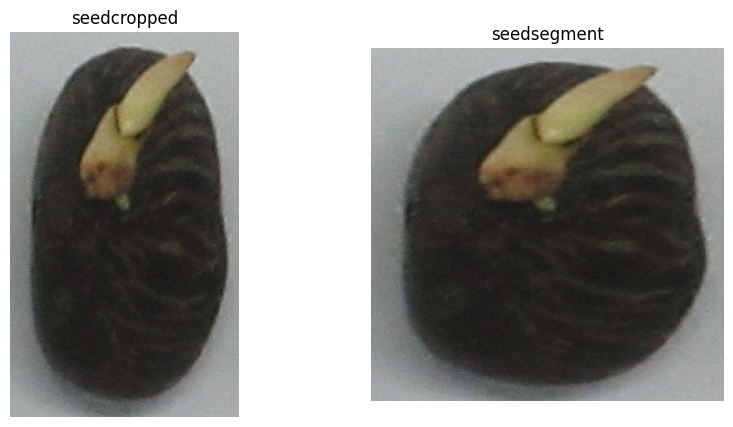



Batch 3, sample: 'badtest13.jpg'


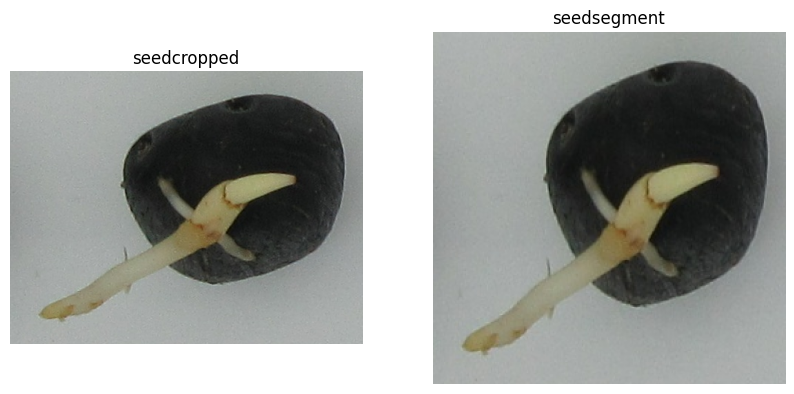

In [20]:
def display_side_by_side(imgpath1, imgpath2):
  # Load images
  img1 = cv2.imread(imgpath1)
  img2 = cv2.imread(imgpath2)

  # Convert images from BGR to RGB (OpenCV reads images in BGR format)
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

  # Create a figure and subplots
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  # Plot images side by side
  axs[0].imshow(img1)
  axs[0].axis('off')
  axs[0].set_title('seedcropped')

  axs[1].imshow(img2)
  axs[1].axis('off')
  axs[1].set_title('seedsegment')

  # Display the plot
  plt.show()


print("Batch 2, sample: 'badtest11.jpg'")
b2imgpath1 = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedcropped/test/BadSeed/badtest11.jpg'
b2imgpath2 = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedsegment/test/BadSeed/badtest11.jpg'

display_side_by_side(b2imgpath1, b2imgpath2)

print("\n\nBatch 3, sample: 'badtest13.jpg'")
b3imgpath1 = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedcropped/test/BadSeed/badtest13.jpg'
b3imgpath2 = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedsegment/test/BadSeed/badtest13.jpg'

display_side_by_side(b3imgpath1, b3imgpath2)


# Custom Seed Dataset and Dataloader


In [21]:
# Custom dataset class inheriting from the PyTorch Dataset class
class SeedDataset(Dataset):
    def __init__(self, dataset_dir=None, train=True, transform=None):
        self.dataset_dir = dataset_dir
        self.train = train
        self.transform = transform
        self.categories = ['BadSeed', 'GoodSeed']
                
        self.data = []
        
        data_dir = os.path.join(self.dataset_dir, 'train' if self.train else 'test')
        for category_idx, category in enumerate(self.categories):
          category_dir = os.path.join(data_dir, category)
          for img_name in os.listdir(category_dir):
              if img_name.endswith('.png') or img_name.endswith('.jpg'):
                  self.data.append((img_name, os.path.join(category_dir, img_name), category_idx))
        
        #print(self.data)
                    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
      
      img_name, img_path, label = self.data[idx]

      # Read the image file in BGR format
      image_bgr = cv2.imread(img_path)
      
      # Convert the image from BGR to RGB format
      seed_img = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

      
      if self.transform:
          seed_img = self.transform(seed_img)

      return img_name, seed_img, label

In [22]:
# Defining paths to dataset directories
batch1_dataset_dir = os.path.join(dataset_root_dir, 'Batch-1/seedsegment')
batch2_dataset_dir = os.path.join(dataset_root_dir, 'Batch-2/seedsegment')
batch3_dataset_dir = os.path.join(dataset_root_dir, 'Batch-3/seedsegment')

In [23]:
# Define the image transformations
image_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [24]:
# Define batch size
BATCH_SIZE = 32

In [25]:
# Instantiate the custom SeedDataset and dataloader
train_dataset = SeedDataset(dataset_dir=batch1_dataset_dir, train=True, transform=image_transforms)
test_batch1_dataset = SeedDataset(dataset_dir=batch1_dataset_dir, train=False, transform=image_transforms)
test_batch2_dataset = SeedDataset(dataset_dir=batch2_dataset_dir, train=False, transform=image_transforms)
test_batch3_dataset = SeedDataset(dataset_dir=batch3_dataset_dir, train=False, transform=image_transforms)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_batch1_dataloader = DataLoader(dataset=test_batch1_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_batch2_dataloader = DataLoader(dataset=test_batch2_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_batch3_dataloader = DataLoader(dataset=test_batch3_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## Testing dataset and dataloader

In [26]:
# Checking the dataset length and a sample of data
print(f"B1 Train Dataset length: {len(train_dataset.data)}")
print(f"B1 Train Data sample: {train_dataset.data[0]}\n")

print(f"B1 Test Dataset length: {len(test_batch1_dataset.data)}")
print(f"B1 Test Data sample: {test_batch1_dataset.data[0]}\n")

print(f"B2 Test Dataset length: {len(test_batch2_dataset.data)}")
print(f"B2 Test Data sample: {test_batch2_dataset.data[0]}\n")

print(f"B3 Test Dataset length: {len(test_batch3_dataset.data)}")
print(f"B3 Test Data sample: {test_batch3_dataset.data[0]}\n")

B1 Train Dataset length: 1752
B1 Train Data sample: ('badtrain0.png', '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-1/seedsegment/train/BadSeed/badtrain0.png', 0)

B1 Test Dataset length: 401
B1 Test Data sample: ('badtest2.png', '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-1/seedsegment/test/BadSeed/badtest2.png', 0)

B2 Test Dataset length: 900
B2 Test Data sample: ('badtest10.jpg', '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedsegment/test/BadSeed/badtest10.jpg', 0)

B3 Test Dataset length: 1198
B3 Test Data sample: ('badtest10.jpg', '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedsegment/test/BadSeed/badtest10.jpg', 0)



In [27]:
# Get a batch of data from the data loader
train_img_names, train_images, train_labels = next(iter(train_dataloader))
b1_test_img_names, b1_test_images, b1_test_labels = next(iter(test_batch1_dataloader))
b2_test_img_names, b2_test_images, b2_test_labels = next(iter(test_batch2_dataloader))
b3_test_img_names, b3_test_images, b3_test_labels = next(iter(test_batch3_dataloader))

### Visualise batches

Train image batch shape: torch.Size([32, 3, 256, 256])
Train labels batch shape: torch.Size([32])
Train labels: tensor([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 0])


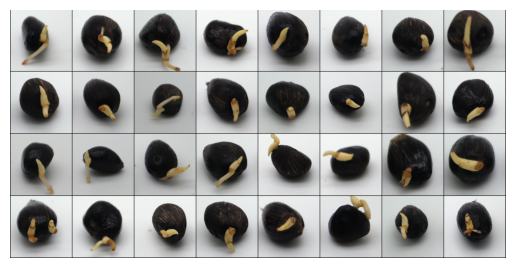

In [28]:
# Train batch
print(f"Train image batch shape: {train_images.size()}")
print(f"Train labels batch shape: {train_labels.size()}")
print(f"Train labels: {train_labels}")

# Create a grid of images from the batch to see the individual seed samples
grid = vutils.make_grid(train_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

B1 Test image batch shape: torch.Size([32, 3, 256, 256])
B1 Test labels batch shape: torch.Size([32])
B1 Test Labels: tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 0, 0, 0, 1, 0, 0])


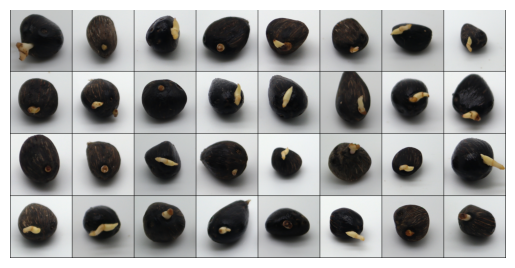

In [29]:
# Test B1
print(f"B1 Test image batch shape: {b1_test_images.size()}")
print(f"B1 Test labels batch shape: {b1_test_labels.size()}")
print(f"B1 Test Labels: {b1_test_labels}")

# Create a grid of images from the batch to see the individual seed samples
grid = vutils.make_grid(b1_test_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

B2 Test image batch shape: torch.Size([32, 3, 256, 256])
B2 Test labels batch shape: torch.Size([32])
B2 Test Labels: tensor([1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 0])


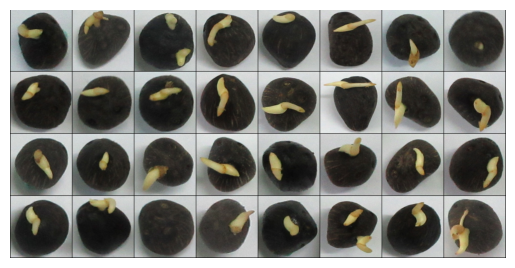

In [30]:
# Test B2
print(f"B2 Test image batch shape: {b2_test_images.size()}")
print(f"B2 Test labels batch shape: {b2_test_labels.size()}")
print(f"B2 Test Labels: {b2_test_labels}")

# Create a grid of images from the batch to see the individual seed samples
grid = vutils.make_grid(b2_test_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

B3 Test image batch shape: torch.Size([32, 3, 256, 256])
B3 Test labels batch shape: torch.Size([32])
B3 Test Labels: tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        1, 1, 0, 1, 1, 0, 1, 1])


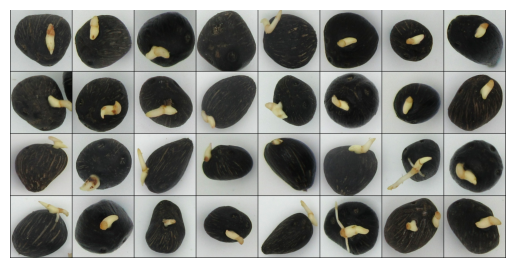

In [31]:
# Test B3
print(f"B3 Test image batch shape: {b3_test_images.size()}")
print(f"B3 Test labels batch shape: {b3_test_labels.size()}")
print(f"B3 Test Labels: {b3_test_labels}")
# Create a grid of images from the batch to see the individual seed sample
grid = vutils.make_grid(b3_test_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()